## 1D FEM

In [1]:
import numpy as np
import functools
import matplotlib.pyplot as plt
from GaussQuad import *

--- 

$$
\frac{d\sigma}{dx} + f = 0, Domain: 0 \to L \\
\sigma = E\frac{du}{dx} \\
u(0) = u0 \\
u`(L) = t \\
$$
- Uniform sized elements (h = constant)
- E = constant
- Linear Basis Function
- Dirichlet and Neumann Boundary Condition

In [25]:
def elementDomain(N, domain, h):
    X = np.zeros((N+1,2))
    for element in range(1,N+1):
        X[element][0] = domain[0] + (element-1)*h
        X[element][1] = domain[0] + (element)*h
    return X

## Defining the Linear Basis Function in Xi domain (-1, 1)
def linearBF(a, xi):
    if a == 1: 
        return (1-xi)/2
    elif a == 2:
        return (1+xi)/2

## Defining the derivative of Basis Function in Xi domain (-1,1)
def delLinearBF(a,xi):
    if a == 1:
        return (-1/2)
    elif a == 2:
        return (1/2)

## Defining isoparametric Mapping from Xi to X
def xOfXi(X, element, xi):
    return X[element][0]*linearBF(1,xi) + X[element][1]*linearBF(2,xi) 

def g11(xi):
    ans = 1
    for i in [1,1]:
        ans = ans*delLinearBF(i, xi)
    return np.array([ans]);

def g12(xi):
    ans = 1
    for i in [1,2]:
        ans = ans*delLinearBF(i, xi)
    return np.array([ans]);

def g21(xi):
    ans = 1
    for i in [2,1]:
        ans = ans*delLinearBF(i, xi)
    return np.array([ans]);

def g22(xi):
    ans = 1
    for i in [2,2]:
        ans = ans*delLinearBF(i, xi)
    return np.array([ans]);

def g(A):
    if A[0] == 1 and A[1] == 1:
        return g11
    
    if A[0] == 1 and A[1] == 2:
        return g12
    
    if A[0] == 2 and A[1] == 1:
        return g21
    
    if A[0] == 2 and A[1] == 2:
        return g22
        
def h1(X, element, xi):
    return linearBF(1, xi)*forceFunc(xOfXi(X,element,xi));

def h2(X, element, xi):
    return linearBF(2, xi)*forceFunc(xOfXi(X,element,xi));

def H(A):
    if A == 1:
        return h1;
    if A == 2: 
        return h2;

def FEM_stressStrain(N, h, X, n, E, U0, t, gqpoint):
    ## Creating local stiffness matrix and assembling global stiffness matirx
    A = np.zeros((N+1,N+1))
    b = np.zeros(N+1)

    for element in range(1,N+1):
        A_local = np.zeros((n,n))
        #H_local = np.zeros(n)

        for i in range(1,n+1):
            for j in range(1,n+1):
                gij = g([i,j])
                A_local[i-1][j-1] = (2*E/h)*gaussQuad(gij, gqpoint, -1, 1)

        A[element-1:element-1+n, element-1:element-1+n] += A_local

    b = np.zeros(N+1)
    #print("b Shape: ", b.shape)

    for element in range(1, N+1):
        b_local = np.zeros((n))
        for i in range(1,n+1):
            hi = H(i)
            hi_partial = functools.partial(hi, X, element)
            b_local[i-1] = (h/2)*gaussQuad(hi_partial, gqpoint, -1, 1)
        b[element-1:element-1+n] += b_local

    #### Dirichlet BC ####
    A[0,0] = 1
    A[0,1] = 0
    b[0] = U0

    #### Neumann BC ####
    b[-1] += t

    # print("A: \n",A)
    # print("B: \n",b)

    exactSol = np.zeros(N+1)
    for i in range(N+1):
        exactSol[i] = analyticSol(i*h)
    
    approxSol = np.matmul(np.linalg.inv(A), b)
    error = np.linalg.norm(approxSol-exactSol)*(h**(0.5))
    
    # print("Approx Sol: ", approxSol)
    # print("Exact Sol: ", exactSol)
    #print("Error: ", error)
    
    return error

--- 

## Equation
$$
\frac{d^2u}{dx^2} = -(\pi^2)\sin(\pi x), Domain: 0 \to 1 
$$

$$
E = 1 \\
f = (\pi^2)\sin(\pi x) \\
L = 1
$$

In [26]:
def forceFunc(x):
    return (np.pi**2)*(np.sin(np.pi*x)) 

def analyticSol(x):
    return np.sin(np.pi*x)

In [27]:
## Parameters

## BC ##
U0 = 0  ## Dirichlet ##
t = -np.pi  ## Neumann ##

## Degree of basis function
# d = 1

E = 1

## Nodes per element
n = 2 

## Domain
domain = [0,1]

# GuassQuad points
gqpoint = 1

## Number of divisions of the domain
N_list = [2**5-1, 2**6-1, 2**7-1, 2**8-1, 2**9-1]
errors = []
h_list = []

for N in N_list:
    # Element length
    h = (domain[1]-domain[0])/N
    h_list.append(h)
    
    X = elementDomain(N, domain, h)

    error = FEM_stressStrain(N, h, X, n, E, U0, t, gqpoint)
    errors.append(error)
#     print(error)

In [28]:
i = 0
d = 4
(np.log(errors[i+d])-np.log(errors[i]))/(np.log(h_list[i+d])-np.log(h_list[i]))

2.01460530005733

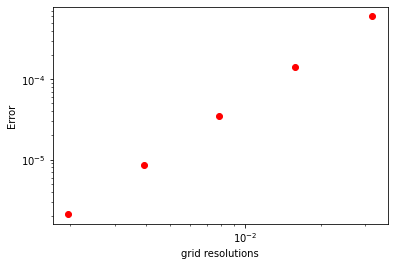

In [29]:
plt.plot(h_list,errors, 'ro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('grid resolutions')
plt.ylabel('Error')
plt.show()

---

## Helmholtz Equation
$$
\frac{d^2u}{dx^2} + K^2u = 0, Domain: 0 \to \pi 
$$

### Exact Solution
$$
u = \sin(Kx)
$$

### Boundary Condition
$$
u(0) = u0 \\
u`(\pi) = -K
$$

<!-- $$
E = 1 \\
f = (\pi^2)\sin(\pi x) \\
L = 1
$$ -->

In [7]:
def forceFunc(x):
    return 0 

def analyticSol(K,x):
    return np.sin(K*x)

In [8]:
def I11(xi):
    ans = 1
    for i in [1,1]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I12(xi):
    ans = 1
    for i in [1,2]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I21(xi):
    ans = 1
    for i in [2,1]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I22(xi):
    ans = 1
    for i in [2,2]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I(A):
    if A[0] == 1 and A[1] == 1:
        return I11
    
    if A[0] == 1 and A[1] == 2:
        return I12
    
    if A[0] == 2 and A[1] == 1:
        return I21
    
    if A[0] == 2 and A[1] == 2:
        return I22
    

def FEM_Helmholtz(N, h, X, n, K, U0, t, gqpoint):
    ## Creating local stiffness matrix and assembling global stiffness matirx
    A = np.zeros((N+1,N+1))
    b = np.zeros(N+1)

    for element in range(1,N+1):
        A_local = np.zeros((n,n))

        for i in range(1,n+1):
            for j in range(1,n+1):
#                 A_local = np.array([[-0.75, 2],[2, -0.75]])
                gij = g([i,j])
                Iij = I([i,j])
                
#                 temp1 = gaussQuad(gij, gqpoint, -1, 1)
#                 temp2 = gaussQuad(Iij, gqpoint, -1, 1)
#                 print("Temp 1:", temp1)
#                 print("Temp 2:", temp2)
#                 print("temp1 + temp2:", temp1+temp2)
                A_local[i-1][j-1] = (2/h)*gaussQuad(gij, gqpoint, -1, 1)
                A_local[i-1][j-1] -= ((K**2)*h/2)*gaussQuad(Iij, gqpoint, -1, 1)

        A[element-1:element-1+n, element-1:element-1+n] += A_local

    b = np.zeros(N+1)
    #print("b Shape: ", b.shape)

    for element in range(1, N+1):
        b_local = np.zeros((n))
        for i in range(1,n+1):
            hi = H(i)
            hi_partial = functools.partial(hi, X, element)

            b_local[i-1] = (h/2)*gaussQuad(hi_partial, gqpoint, -1, 1)
        b[element-1:element-1+n] += b_local

    #### Dirichlet BC ####
    A[0,0] = 1
    A[0,1] = 0
    b[0] = U0

    #### Neumann BC ####
    b[-1] += t

#     print("A: \n",A)
#     print("B: \n",b)

    exactSol = np.zeros(N+1)
    for i in range(N+1):
        exactSol[i] = analyticSol(K, i*h)
    
    approxSol = np.matmul(np.linalg.inv(A), b)
    error = np.linalg.norm(approxSol-exactSol)*(h**(0.5))
    
#     print("Approx Sol: ", approxSol)
#     print("Exact Sol: ", exactSol)
#     print("Error: ", error)
    
    return error

In [9]:
## Parameters
K = 3
## BC ##
U0 = 0  ## Dirichlet ##
t = ((-1)**K)*K  ## Neumann ##

## Degree of basis function
# d = 1

## Nodes per element
n = 2 

## Domain
domain = [0,np.pi]

# GuassQuad points
gqpoint = 1

## Number of divisions of the domain
N_list = [2**5-1, 2**6-1, 2**7-1, 2**8-1, 2**9-1]
errors = []
h_list = []

for N in N_list:
    # Element length
    h = (domain[1]-domain[0])/N
#     print("h:", h)
    h_list.append(h)
    
    X = elementDomain(N, domain, h)

    error = FEM_Helmholtz(N, h, X, n, K, U0, t, gqpoint)
    errors.append(error)
#     print(error)

In [10]:
i = 0
d = 4
(np.log(errors[i+d])-np.log(errors[i]))/(np.log(h_list[i+d])-np.log(h_list[i]))

2.011551428858359

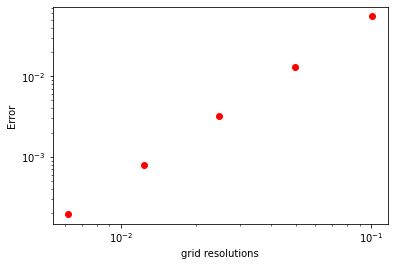

In [11]:
plt.plot(h_list,errors, 'ro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('grid resolutions')
plt.ylabel('Error')
plt.show()

---

## Bratu

In [12]:
def forceFunc(x):
    return 0 

def analyticSol(K,x):
    return np.sin(K*x)

def approxSol(U, element, xi):
    ans = 0
    for i in [1,2]:
        ans += linearBF(i, xi)*U[element+i-1]
    return ans

def delApproxSol(U, element, xi, h):
    ans = 0
    for i in [1,2]:
        ans += (2/h)*delLinearBF(i, xi)*U[element+i-1]
    return ans

In [22]:
def I11(U, element, xi):
    ans = np.exp(approxSol(U, element, xi))
    for i in [1,1]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I12(U, element, xi):
    ans = np.exp(approxSol(U, element, xi))
    for i in [1,2]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I21(U, element, xi):
    ans = np.exp(approxSol(U, element, xi))
    for i in [2,1]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I22(U, element, xi):
    ans = np.exp(approxSol(U, element, xi))
    for i in [2,2]:
        ans = ans*linearBF(i, xi)
    return np.array([ans]);

def I(A):
    if A[0] == 1 and A[1] == 1:
        return I11
    
    if A[0] == 1 and A[1] == 2:
        return I12
    
    if A[0] == 2 and A[1] == 1:
        return I21
    
    if A[0] == 2 and A[1] == 2:
        return I22
    
def h1(U, element, xi):
    return linearBF(1, xi)*np.exp(approxSol(U, element, xi));

def h2(U, element, xi):
    return linearBF(2, xi)*np.exp(approxSol(U, element, xi));

def H(A):
    if A == 1:
        return h1;
    if A == 2: 
        return h2;
    
def k1(U, element, h, xi):
    return delLinearBF(1, xi)*delApproxSol(U, element, xi, h);

def k2(U, element, h, xi):
    return delLinearBF(2, xi)*delApproxSol(U, element, xi, h);

def K(A):
    if A == 1:
        return k1;
    if A == 2: 
        return k2;

def FEM_Bratu(N, h, X, n, lamda, U0, t, gqpoint):
    ## Creating local stiffness matrix and assembling global stiffness matirx
    A = np.zeros((N+1,N+1))
    b = np.zeros(N+1)
    U_lastStep = np.random.rand(N+1)
    delU = 1
    
    while delU > 10**(-6):
        for element in range(1,N+1):
            A_local = np.zeros((n,n))

            for i in range(1,n+1):
                for j in range(1,n+1):
    #                 A_local = np.array([[-0.75, 2],[2, -0.75]])
                    gij = g([i,j])
                    Iij = I([i,j])
                    Iij_partial = functools.partial(Iij, U_lastStep, element)

                    A_local[i-1][j-1] = (2/h)*gaussQuad(gij, gqpoint, -1, 1)
                    A_local[i-1][j-1] -= (lamda*h/2)*gaussQuad(Iij_partial, gqpoint, -1, 1)

            A[element-1:element-1+n, element-1:element-1+n] += A_local

        b = np.zeros(N+1)
        #print("b Shape: ", b.shape)

        for element in range(1, N+1):
            b_local = np.zeros((n))
            for i in range(1,n+1):
                hi = H(i)
                ki = K(i)
                hi_partial = functools.partial(hi, U_lastStep, element)
                ki_partial = functools.partial(ki, U_lastStep, element, h)

                b_local[i-1] = (lamda*h/2)*gaussQuad(hi_partial, gqpoint, -1, 1)
                b_local[i-1] -= gaussQuad(ki_partial, gqpoint, -1, 1)
            b[element-1:element-1+n] += b_local

        #### Dirichlet BC ####
        A[0,0] = 1
        A[0,1] = 0
        b[0] = U0

        #### Neumann BC ####
        b[-1] += t

    #     print("A: \n",A)
    #     print("B: \n",b)

        delU = np.matmul(np.linalg.inv(A), b)
        U_lastStep = U_lastStep + delU
    
    exactSol = np.zeros(N+1)
    for i in range(N+1):
        exactSol[i] = analyticSol(K, i*h)
    
    error = np.linalg.norm(approxSol-exactSol)*(h**(0.5))
    
#     print("Approx Sol: ", approxSol)
#     print("Exact Sol: ", exactSol)
#     print("Error: ", error)
    
    return error

In [24]:
## Parameters
K = 2
## BC ##
U0 = 0  ## Dirichlet ##
t = K  ## Neumann ##

## Degree of basis function
# d = 1

## Nodes per element
n = 2 

## Domain
domain = [0,np.pi]

# GuassQuad points
gqpoint = 1

## Number of divisions of the domain
N_list = [2**5-1, 2**6-1, 2**7-1, 2**8-1, 2**9-1]
errors = []
h_list = []

for N in N_list:
    # Element length
    h = (domain[1]-domain[0])/N
#     print("h:", h)
    h_list.append(h)
    
    X = elementDomain(N, domain, h)

    error = FEM_Bratu(N, h, X, n, K, U0, t, gqpoint)
    errors.append(error)
    print(error)

IndexError: index 32 is out of bounds for axis 0 with size 32

In [ ]:
i = 0
d = 4
(np.log(errors[i+d])-np.log(errors[i]))/(np.log(h_list[i+d])-np.log(h_list[i]))

In [ ]:
plt.plot(h_list,errors, 'ro')
plt.xscale('log')
plt.yscale('log')
plt.xlabel('grid resolutions')
plt.ylabel('Error')
plt.show()